# **Task 3**
## **Performing Machine Learning model using Spark MLlib**

# **Setup**

In [1]:
!pip install pyspark -q

In [17]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, month, year, mean, count, when, to_date
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [3]:
spark = SparkSession.builder \
    .appName("EvapotranspirationPrediction") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print("spark version: ", spark.version)

spark version:  4.0.1


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [9]:
weatherDataPath = "/content/drive/MyDrive/CMM705 - Big Data Programming/weatherData.csv"
locationDataPath = "/content/drive/MyDrive/CMM705 - Big Data Programming/locationData.csv"


In [10]:
weather_df = spark.read.csv(weatherDataPath, header=True, inferSchema=True)

In [11]:
location_df = spark.read.csv(locationDataPath, header=True, inferSchema=True)

In [12]:
weather_df.show(5)

+-----------+--------+-----------------------+-----------------------+-----------------------+------------------------+-----------------------------+-----------------------------+------------------------------+---------------------+---------------------+----------------------+-------------+-----------------------+-------------------------+-------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------+-------------------+
|location_id|    date|weather_code (wmo code)|temperature_2m_max (°C)|temperature_2m_min (°C)|temperature_2m_mean (°C)|apparent_temperature_max (°C)|apparent_temperature_min (°C)|apparent_temperature_mean (°C)|daylight_duration (s)|sunshine_duration (s)|precipitation_sum (mm)|rain_sum (mm)|precipitation_hours (h)|wind_speed_10m_max (km/h)|wind_gusts_10m_max (km/h)|wind_direction_10m_dominant (°)|shortwave_radiation_sum (MJ/m²)|et0_fao_evapotranspiration (mm)|            sunrise|             

In [13]:
location_df.show(5)

+-----------+---------+---------+---------+------------------+------------+---------------------+---------+
|location_id| latitude|longitude|elevation|utc_offset_seconds|    timezone|timezone_abbreviation|city_name|
+-----------+---------+---------+---------+------------------+------------+---------------------+---------+
|          0| 6.924429| 79.90725|        4|             19800|Asia/Colombo|                  530|  Colombo|
|          1|7.0650263| 79.96622|       19|             19800|Asia/Colombo|                  530|  Gampaha|
|          2| 6.572935| 80.02519|        5|             19800|Asia/Colombo|                  530| Kalutara|
|          3| 7.275923| 80.62659|      499|             19800|Asia/Colombo|                  530|    Kandy|
|          4|7.4868193| 80.52632|      362|             19800|Asia/Colombo|                  530|   Matale|
+-----------+---------+---------+---------+------------------+------------+---------------------+---------+
only showing top 5 rows


# **Pre-processing**

In [14]:
missing_counts = weather_df.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in weather_df.columns
])
missing_counts.show()

+-----------+----+-----------------------+-----------------------+-----------------------+------------------------+-----------------------------+-----------------------------+------------------------------+---------------------+---------------------+----------------------+-------------+-----------------------+-------------------------+-------------------------+-------------------------------+-------------------------------+-------------------------------+-------+------+
|location_id|date|weather_code (wmo code)|temperature_2m_max (°C)|temperature_2m_min (°C)|temperature_2m_mean (°C)|apparent_temperature_max (°C)|apparent_temperature_min (°C)|apparent_temperature_mean (°C)|daylight_duration (s)|sunshine_duration (s)|precipitation_sum (mm)|rain_sum (mm)|precipitation_hours (h)|wind_speed_10m_max (km/h)|wind_gusts_10m_max (km/h)|wind_direction_10m_dominant (°)|shortwave_radiation_sum (MJ/m²)|et0_fao_evapotranspiration (mm)|sunrise|sunset|
+-----------+----+-----------------------+--------

In [18]:
weather_df.select(
    to_date(col("date"), "M/d/yyyy").alias("date")
).where(col("date").isNotNull()) \
 .agg(
    {"date": "min", "date": "max"}
 ).show()


+----------+
| max(date)|
+----------+
|2024-06-08|
+----------+



In [19]:
#convert sunshine duration to hours

weather_df = weather_df.withColumn(
    "sunshine_hours",
    col("sunshine_duration (s)") / 3600
)

In [25]:
#filtering data for May

weather_may = weather_df.withColumn(
    "date_parsed",
    to_date(col("date"), "M/d/yyyy")
).filter(
    month(col("date_parsed")) == 5
)

In [26]:
#final count

weather_may.count()

12555

In [28]:
weather_may.show(10)

+-----------+---------+-----------------------+-----------------------+-----------------------+------------------------+-----------------------------+-----------------------------+------------------------------+---------------------+---------------------+----------------------+-------------+-----------------------+-------------------------+-------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------+-------------------+------------------+-----------+
|location_id|     date|weather_code (wmo code)|temperature_2m_max (°C)|temperature_2m_min (°C)|temperature_2m_mean (°C)|apparent_temperature_max (°C)|apparent_temperature_min (°C)|apparent_temperature_mean (°C)|daylight_duration (s)|sunshine_duration (s)|precipitation_sum (mm)|rain_sum (mm)|precipitation_hours (h)|wind_speed_10m_max (km/h)|wind_gusts_10m_max (km/h)|wind_direction_10m_dominant (°)|shortwave_radiation_sum (MJ/m²)|et0_fao_evapotranspiration (mm)|

In [29]:
weather_may.describe().show()

+-------+-----------------+--------+-----------------------+-----------------------+-----------------------+------------------------+-----------------------------+-----------------------------+------------------------------+---------------------+---------------------+----------------------+------------------+-----------------------+-------------------------+-------------------------+-------------------------------+-------------------------------+-------------------------------+------------------+
|summary|      location_id|    date|weather_code (wmo code)|temperature_2m_max (°C)|temperature_2m_min (°C)|temperature_2m_mean (°C)|apparent_temperature_max (°C)|apparent_temperature_min (°C)|apparent_temperature_mean (°C)|daylight_duration (s)|sunshine_duration (s)|precipitation_sum (mm)|     rain_sum (mm)|precipitation_hours (h)|wind_speed_10m_max (km/h)|wind_gusts_10m_max (km/h)|wind_direction_10m_dominant (°)|shortwave_radiation_sum (MJ/m²)|et0_fao_evapotranspiration (mm)|    sunshine_hou

In [30]:
feature_cols = [
    "precipitation_hours (h)",
    "sunshine_hours",
    "wind_speed_10m_max (km/h)",
    "et0_fao_evapotranspiration (mm)"
]

In [31]:
# headers clean up

weather_may = weather_may.withColumnRenamed("precipitation_hours (h)", "precipitation_hours") \
                         .withColumnRenamed("wind_speed_10m_max (km/h)", "wind_speed") \
                         .withColumnRenamed("et0_fao_evapotranspiration (mm)", "evapotranspiration")

In [32]:
# removing null values and selecte required headers

df_clean = weather_may.select(
    "precipitation_hours",
    "sunshine_hours",
    "wind_speed",
    "evapotranspiration"
).na.drop()

In [33]:
df_clean.describe().show()

+-------+-------------------+------------------+-----------------+------------------+
|summary|precipitation_hours|    sunshine_hours|       wind_speed|evapotranspiration|
+-------+-------------------+------------------+-----------------+------------------+
|  count|              12555|             12555|            12555|             12555|
|   mean|  8.011867781760255| 9.528481240320387|17.84893667861412| 4.225671843886905|
| stddev|  6.946432602146947|2.5585355610205562|7.709660922461054|1.1799446246284135|
|    min|                  0|               0.0|              2.5|              0.59|
|    max|                 24|11.708086111111111|             48.3|              8.45|
+-------+-------------------+------------------+-----------------+------------------+



# **Feature Analysis**

In [34]:
pandas_df = df_clean.toPandas()

In [35]:
correlation_matrix = pandas_df.corr()
print("Correlation Matrix: ", correlation_matrix)


Correlation Matrix:                       precipitation_hours  sunshine_hours  wind_speed  \
precipitation_hours             1.000000       -0.532846   -0.118198   
sunshine_hours                 -0.532846        1.000000    0.153150   
wind_speed                     -0.118198        0.153150    1.000000   
evapotranspiration             -0.743033        0.739416    0.399353   

                     evapotranspiration  
precipitation_hours           -0.743033  
sunshine_hours                 0.739416  
wind_speed                     0.399353  
evapotranspiration             1.000000  


In [36]:
corr = correlation_matrix["evapotranspiration"].sort_values(ascending=False)
print(corr)

evapotranspiration     1.000000
sunshine_hours         0.739416
wind_speed             0.399353
precipitation_hours   -0.743033
Name: evapotranspiration, dtype: float64


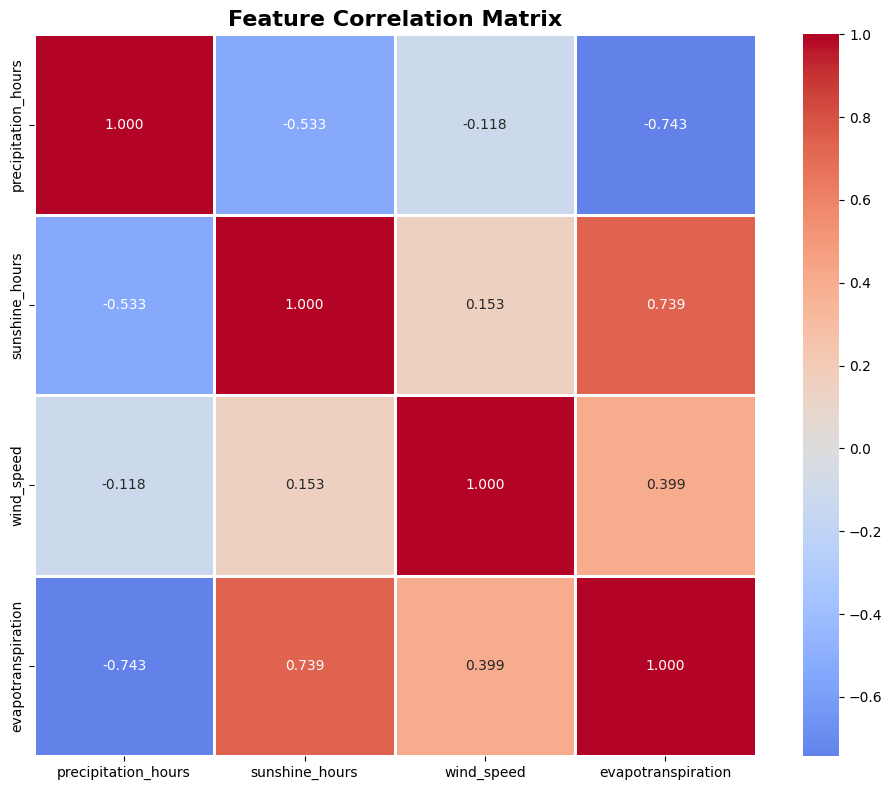

In [37]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=1,
    fmt='.3f'
)
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [38]:
low_evapotranspiration = df_clean.filter(col("evapotranspiration") < 1.5)

In [39]:
low_evapotranspiration.describe().show()


+-------+-------------------+------------------+-----------------+-------------------+
|summary|precipitation_hours|    sunshine_hours|       wind_speed| evapotranspiration|
+-------+-------------------+------------------+-----------------+-------------------+
|  count|                134|               134|              134|                134|
|   mean| 22.134328358208954|0.4425161069651742|18.49029850746269| 1.1911194029850745|
| stddev|   3.03808171762202|0.7451695811212667|7.489841435054108|0.22775682998684355|
|    min|                 11|               0.0|              4.2|               0.59|
|    max|                 24| 4.848052777777778|             40.0|               1.49|
+-------+-------------------+------------------+-----------------+-------------------+



In [41]:
low_et_means = low_evapotranspiration.agg(
    mean("precipitation_hours").alias("mean_precip"),
    mean("sunshine_hours").alias("mean_sunshine"),
    mean("wind_speed").alias("mean_wind"),
    mean("evapotranspiration").alias("mean_et")
).collect()[0]

print(low_et_means)

Row(mean_precip=22.134328358208954, mean_sunshine=0.4425161069651742, mean_wind=18.49029850746269, mean_et=1.1911194029850745)


# **Feature extraction and vector assembly**

In [42]:
feature_columns = ["precipitation_hours", "sunshine_hours", "wind_speed"]
target_column = "evapotranspiration"

In [43]:
assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol="features_raw"
)

In [45]:
scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features",
    withStd=True,
    withMean=True
)

print(scaler)

StandardScaler_08a67fde01e6


# **Data split**

In [46]:
train_data, validation_data = df_clean.randomSplit([0.8, 0.2], seed=42)

In [47]:
print("Train data count: ", train_data.count())
print("Validation data count: ", validation_data.count())

Train data count:  10128
Validation data count:  2427


In [48]:
train_data.describe().show()

+-------+-------------------+------------------+-----------------+------------------+
|summary|precipitation_hours|    sunshine_hours|       wind_speed|evapotranspiration|
+-------+-------------------+------------------+-----------------+------------------+
|  count|              10128|             10128|            10128|             10128|
|   mean|  7.995754344391785| 9.528870607337213| 17.8984103475513|  4.23058056872037|
| stddev| 6.9545408287903285|2.5470974852003523|7.742766937891595|1.1819634767366058|
|    min|                  0|               0.0|              2.5|              0.59|
|    max|                 24|11.708086111111111|             48.3|              8.45|
+-------+-------------------+------------------+-----------------+------------------+



In [49]:
validation_data.describe().show()

+-------+-------------------+------------------+------------------+------------------+
|summary|precipitation_hours|    sunshine_hours|        wind_speed|evapotranspiration|
+-------+-------------------+------------------+------------------+------------------+
|  count|               2427|              2427|              2427|              2427|
|   mean|  8.079110012360939| 9.526856391063504|17.642480428512584| 4.205187474248044|
| stddev|  6.913516245336879|2.6062571194550985|   7.5680275719973|1.1715024755264314|
|    min|                  0|               0.0|               2.5|              0.74|
|    max|                 24|11.706744444444444|              46.2|              8.02|
+-------+-------------------+------------------+------------------+------------------+



# **Linear Regression**

In [50]:
lr = LinearRegression(
    featuresCol="features",
    labelCol=target_column,
    predictionCol="prediction",
    maxIter=200,
    regParam=0.0,
    elasticNetParam=0.0
)

In [51]:
pipeline_lr = Pipeline(stages=[assembler, scaler, lr])

In [52]:
#training

lr_model = pipeline_lr.fit(train_data)

In [53]:
lr_stage = lr_model.stages[-1]
coefficients = lr_stage.coefficients.toArray()
intercept = lr_stage.intercept

print("Coefficients: ", coefficients)
print("Intercept: ", intercept)
print("RMSE: ", lr_stage.summary.rootMeanSquaredError)

Coefficients:  [-0.55872311  0.52686987  0.32988595]
Intercept:  4.230580568720362
RMSE:  0.5404199457928056


In [54]:
for i, feature in enumerate(feature_columns):
  print(f"{feature}: {coefficients[i]:.6f}")

precipitation_hours: -0.558723
sunshine_hours: 0.526870
wind_speed: 0.329886


In [55]:
equation = f"ET = {intercept:.4f}"
for i, feature in enumerate(feature_columns):
  sign = "+" if coefficients[i] >= 0 else ""
  equation += f" {sign} {coefficients[i]:.4f}*{feature}"

print(equation)

ET = 4.2306  -0.5587*precipitation_hours + 0.5269*sunshine_hours + 0.3299*wind_speed


# **Random Forest**

In [56]:
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol=target_column,
    predictionCol="prediction",
    numTrees=100,
    maxDepth=10,
    minInstancesPerNode=5,
    seed=42
)

In [57]:
pipeline_rf = Pipeline(stages=[assembler, scaler, rf])


In [58]:
rf_model = pipeline_rf.fit(train_data)

In [60]:
rf_stage = rf_model.stages[-1]
importances = rf_stage.featureImportances.toArray()

print("Feature Importances: ", importances)

Feature Importances:  [0.45112523 0.42470836 0.12416641]


In [61]:
for i, feature in enumerate(feature_columns):
  print(f"{feature}: {importances[i]:.4f}")

precipitation_hours: 0.4511
sunshine_hours: 0.4247
wind_speed: 0.1242


# **Gradient boosted tree**

In [62]:
gbt = GBTRegressor(
    featuresCol="features",
    labelCol=target_column,
    predictionCol="prediction",
    maxIter=100,
    maxDepth=5,
    seed=42
)

In [63]:
pipeline_gbt = Pipeline(stages=[assembler, scaler, gbt])

In [64]:
gbt_model = pipeline_gbt.fit(train_data)

In [65]:
gbt_stage = gbt_model.stages[-1]
gbt_importances = gbt_stage.featureImportances.toArray()

print("Feature Importances: ", gbt_importances)

Feature Importances:  [0.48199922 0.34232127 0.17567951]


In [66]:
for i, feature in enumerate(feature_columns):
  print(f"{feature}: {gbt_importances[i]:.4f}")

precipitation_hours: 0.4820
sunshine_hours: 0.3423
wind_speed: 0.1757


# **Evaluation**

In [67]:
lr_predictions = lr_model.transform(validation_data)
rf_predictions = rf_model.transform(validation_data)
gbt_predictions = gbt_model.transform(validation_data)

In [68]:
evaluator_rmse = RegressionEvaluator(
    labelCol=target_column,
    predictionCol="prediction",
    metricName="rmse"
)

In [69]:
evaluator_r2 = RegressionEvaluator(
    labelCol=target_column,
    predictionCol="prediction",
    metricName="r2"
)

In [71]:
evaluator_mae = RegressionEvaluator(
    labelCol=target_column,
    predictionCol="prediction",
    metricName="mae"
)


## Linear Regression

In [72]:
lr_rmse = evaluator_rmse.evaluate(lr_predictions)
lr_r2 = evaluator_r2.evaluate(lr_predictions)
lr_mae = evaluator_mae.evaluate(lr_predictions)

print("Linear Regression - RMSE: ", lr_rmse)
print("Linear Regression - R2: ", lr_r2)
print("Linear Regression - MAE: ", lr_mae)

Linear Regression - RMSE:  0.5372861707423899
Linear Regression - R2:  0.7895718276266344
Linear Regression - MAE:  0.4234792728907934


## Random Forest

In [73]:
rf_rmse = evaluator_rmse.evaluate(rf_predictions)
rf_r2 = evaluator_r2.evaluate(rf_predictions)
rf_mae = evaluator_mae.evaluate(rf_predictions)

print("Random Forest - RMSE: ", rf_rmse)
print("Random Forest - R2: ", rf_r2)
print("Random Forest - MAE: ", rf_mae)

Random Forest - RMSE:  0.46616609484800225
Random Forest - R2:  0.8415931619859724
Random Forest - MAE:  0.36358952629046953


## Gradient Boosted Trees

In [76]:
gbt_rmse = evaluator_rmse.evaluate(gbt_predictions)
gbt_r2 = evaluator_r2.evaluate(gbt_predictions)
gbt_mae = evaluator_mae.evaluate(gbt_predictions)

print("Gradient Boosted Trees - RMSE: ", gbt_rmse)
print("Gradient Boosted Trees - R2: ", gbt_r2)
print("Gradient Boosted Trees - MAE: ", gbt_mae)

Gradient Boosted Trees - RMSE:  0.47100355290806956
Gradient Boosted Trees - R2:  0.8382884928384388
Gradient Boosted Trees - MAE:  0.3674739682446861


In [77]:
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosted Trees'],
    'RMSE': [lr_rmse, rf_rmse, gbt_rmse],
    'R²': [lr_r2, rf_r2, gbt_r2],
    'MAE': [lr_mae, rf_mae, gbt_mae]
})
print(comparison_df.to_string(index=False))

                 Model     RMSE       R²      MAE
     Linear Regression 0.537286 0.789572 0.423479
         Random Forest 0.466166 0.841593 0.363590
Gradient Boosted Trees 0.471004 0.838288 0.367474


In [79]:
best_model_index = comparison_df['R²'].idxmax()
best_model = comparison_df.loc[best_model_index, 'Model']

print("Best Model: ", best_model)

Best Model:  Random Forest


# **Prediction Analysis**

In [80]:
lr_predictions.select(
    "precipitation_hours",
    "sunshine_hours",
    "wind_speed",
    "evapotranspiration",
    "prediction"
).show(20)

+-------------------+------------------+----------+------------------+------------------+
|precipitation_hours|    sunshine_hours|wind_speed|evapotranspiration|        prediction|
+-------------------+------------------+----------+------------------+------------------+
|                  0|1.6661083333333333|      23.1|              3.44| 3.468150514450039|
|                  0| 4.187469444444444|      15.5|              3.47|3.6658935197912346|
|                  0|4.7357861111111115|      24.2|               4.4|  4.14998294641478|
|                  0| 5.658136111111111|      17.6|              3.77| 4.059574466648605|
|                  0| 7.508258333333333|      26.4|              4.83| 4.817204350191338|
|                  0| 7.801880555555556|      24.9|              4.48| 4.814031884720105|
|                  0| 8.219055555555554|       8.5|              4.28|  4.20159161622853|
|                  0|  8.56838611111111|      25.7|              4.11| 5.006668942739271|
|         

In [81]:
lr_pred_pandas = lr_predictions.select(
    "evapotranspiration",
    "prediction"
).toPandas()

In [83]:
lr_pred_pandas['error'] = lr_pred_pandas['evapotranspiration'] - lr_pred_pandas['prediction']
lr_pred_pandas['abs_error'] = np.abs(lr_pred_pandas['error'])
lr_pred_pandas['pct_error'] = (lr_pred_pandas['abs_error'] / lr_pred_pandas['evapotranspiration']) * 100

print(lr_pred_pandas.head(20))
print(lr_pred_pandas.describe())
print("Mean Absolute Error", lr_pred_pandas['abs_error'].mean())
print("Median Absolute Error:", lr_pred_pandas['abs_error'].median())
print("Mean Percentage Error", lr_pred_pandas['pct_error'].mean())
print("Max Error", lr_pred_pandas['abs_error'].max())

    evapotranspiration  prediction     error  abs_error  pct_error
0                 3.44    3.468151 -0.028151   0.028151   0.818329
1                 3.47    3.665894 -0.195894   0.195894   5.645346
2                 4.40    4.149983  0.250017   0.250017   5.682206
3                 3.77    4.059574 -0.289574   0.289574   7.681020
4                 4.83    4.817204  0.012796   0.012796   0.264920
5                 4.48    4.814032 -0.334032   0.334032   7.456069
6                 4.28    4.201592  0.078408   0.078408   1.831972
7                 4.11    5.006669 -0.896669   0.896669  21.816763
8                 5.52    4.746192  0.773808   0.773808  14.018253
9                 5.46    5.208009  0.251991   0.251991   4.615223
10                5.60    5.218408  0.381592   0.381592   6.814148
11                4.87    5.437697 -0.567697   0.567697  11.657029
12                5.52    4.739267  0.780733   0.780733  14.143719
13                5.12    5.495290 -0.375290   0.375290   7.32

# Random Forest

In [84]:
rf_predictions.select(
    "precipitation_hours",
    "sunshine_hours",
    "wind_speed",
    "evapotranspiration",
    "prediction"
).show(20)

+-------------------+------------------+----------+------------------+------------------+
|precipitation_hours|    sunshine_hours|wind_speed|evapotranspiration|        prediction|
+-------------------+------------------+----------+------------------+------------------+
|                  0|1.6661083333333333|      23.1|              3.44|4.0221777516465185|
|                  0| 4.187469444444444|      15.5|              3.47|3.5857896608225177|
|                  0|4.7357861111111115|      24.2|               4.4| 4.277714546675198|
|                  0| 5.658136111111111|      17.6|              3.77| 3.753152031233327|
|                  0| 7.508258333333333|      26.4|              4.83| 4.833183676754803|
|                  0| 7.801880555555556|      24.9|              4.48|4.6014108081925125|
|                  0| 8.219055555555554|       8.5|              4.28| 4.061846156167806|
|                  0|  8.56838611111111|      25.7|              4.11| 4.712676722958862|
|         

In [85]:
rf_pred_pandas = rf_predictions.select(
    "evapotranspiration",
    "prediction"
).toPandas()

In [87]:
rf_pred_pandas['error'] = rf_pred_pandas['evapotranspiration'] - rf_pred_pandas['prediction']
rf_pred_pandas['abs_error'] = np.abs(rf_pred_pandas['error'])
rf_pred_pandas['pct_error'] = (rf_pred_pandas['abs_error'] / rf_pred_pandas['evapotranspiration']) * 100

print(rf_pred_pandas.head(20))
print(rf_pred_pandas.describe())
print("Mean Absolute Error", rf_pred_pandas['abs_error'].mean())
print("Median Absolute Error", rf_pred_pandas['abs_error'].median())
print("Mean Percentage Error", rf_pred_pandas['pct_error'].mean())
print("Max Error", rf_pred_pandas['abs_error'].max())
print("Min Error", rf_pred_pandas['abs_error'].min())
print("Std Dev of Errors", rf_pred_pandas['error'].std())


    evapotranspiration  prediction     error  abs_error  pct_error
0                 3.44    4.022178 -0.582178   0.582178  16.923772
1                 3.47    3.585790 -0.115790   0.115790   3.336878
2                 4.40    4.277715  0.122285   0.122285   2.779215
3                 3.77    3.753152  0.016848   0.016848   0.446896
4                 4.83    4.833184 -0.003184   0.003184   0.065915
5                 4.48    4.601411 -0.121411   0.121411   2.710063
6                 4.28    4.061846  0.218154   0.218154   5.097052
7                 4.11    4.712677 -0.602677   0.602677  14.663667
8                 5.52    4.426403  1.093597   1.093597  19.811533
9                 5.46    5.107444  0.352556   0.352556   6.457069
10                5.60    5.103223  0.496777   0.496777   8.871017
11                4.87    5.166495 -0.296495   0.296495   6.088189
12                5.52    4.450315  1.069685   1.069685  19.378354
13                5.12    5.178830 -0.058830   0.058830   1.14

# Prediction

In [88]:
prediction_input = spark.createDataFrame([
    (float(low_et_means['mean_precip']),
     float(low_et_means['mean_sunshine']),
     float(low_et_means['mean_wind']))
], ["precipitation_hours", "sunshine_hours", "wind_speed"])

prediction_input.show()

+-------------------+------------------+-----------------+
|precipitation_hours|    sunshine_hours|       wind_speed|
+-------------------+------------------+-----------------+
| 22.134328358208954|0.4425161069651742|18.49029850746269|
+-------------------+------------------+-----------------+



In [89]:
rf_pred_2026 = rf_model.transform(prediction_input)

In [90]:
rf_et = rf_pred_2026.select("prediction").first()[0]

In [91]:
print("\nOptimal Input Conditions to achieve ET < 1.5mm:")
print("Precipitation Hours", low_et_means['mean_precip'])
print("Sunshine Hours", low_et_means['mean_sunshine'])
print("Wind Speed", low_et_means['mean_wind'])


Optimal Input Conditions to achieve ET < 1.5mm:
Precipitation Hours 22.134328358208954
Sunshine Hours 0.4425161069651742
Wind Speed 18.49029850746269


In [92]:
print("\nPredicted Evapotranspiration (Random Forest):")
print("Random Forest", rf_et, "mm")

print("\nTarget Achievement:")
print("Target", "< 1.5 mm")
print("Random Forest meets target", "YES" if rf_et < 1.5 else "NO")


Predicted Evapotranspiration (Random Forest):
Random Forest 1.7739296792040165 mm

Target Achievement:
Target < 1.5 mm
Random Forest meets target NO


## Linear Regression prediction

In [97]:
lr_pred_2026 = lr_model.transform(prediction_input)

In [99]:
lr_et = lr_pred_2026.select("prediction").first()[0]

In [100]:
print("\nPredicted Evapotranspiration (Linear Regression):")
print("Linear Regression", lr_et, "mm")

print("\nTarget Achievement:")
print("Target", "< 1.5 mm")
print("Linear Regression meets target", "YES" if lr_et < 1.5 else "NO")


Predicted Evapotranspiration (Linear Regression):
Linear Regression 1.2403926416833384 mm

Target Achievement:
Target < 1.5 mm
Linear Regression meets target YES


In [101]:
## ET = 4.2306  -0.5587*precipitation_hours + 0.5269*sunshine_hours + 0.3299*wind_speed

b0 = 4.230580568720362
b1 = -0.55872311      # precipitation
b2 = 0.52686987       # sunshine
b3 = 0.32988595       # wind

# Target ET
target_et = 1.5

mean_sunshine = low_et_means['mean_sunshine']
mean_wind = low_et_means['mean_wind']

required_precip = (target_et - b0 - b2*mean_sunshine - b3*mean_wind) / b1

print("Optimal mean precipitation_hours for ET < 1.5 mm:", required_precip)
print("Mean sunshine_hours (May 2026):", mean_sunshine)
print("Mean wind_speed (May 2026):", mean_wind)


Optimal mean precipitation_hours for ET < 1.5 mm: 16.221664182438992
Mean sunshine_hours (May 2026): 0.4425161069651742
Mean wind_speed (May 2026): 18.49029850746269
